[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Harvard-CS1090/2026_CS1090B_public/blob/main/sec05/cs1090b_sec05_solutions.ipynb)

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">

# CS1090B Section 5: SOTA Architectures, Transfer Learning, and Visualizing CNNs

**Harvard University**<br/>
**Spring 2026**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb<br/>

## Overview

In Section 4, we built CNNs from scratch, trained them on image classification tasks, and learned how to set up data pipelines in PyTorch. In this section, we go deeper.

- **Part 1** surveys state-of-the-art (SOTA) CNN architectures - Inception, ResNet, VGG, and others - by loading them from `torchvision.models` and comparing their designs.
- **Part 2** introduces **transfer learning** - leveraging pretrained models to achieve strong performance with limited data - covering both **feature extraction** (frozen backbone) and **fine-tuning** (progressively unfreezing pretrained layers).
- **Part 3** explores CNN visualization techniques - saliency maps and class model visualization - to understand *what* a CNN has learned and *why* it makes its predictions.
- **Team Activity** puts it all together: students investigate model predictions using visualization tools.

## Learning Objectives

By the end of this section, you should be able to:

### Conceptual Understanding
1. Describe the key design innovations in Inception (multi-scale filters, 1×1 convolutions, auxiliary classifiers) and ResNet (skip/residual connections).
2. Explain why deeper networks can be harder to train and how residual connections address this (vanishing gradients, identity mappings).
3. Compare transfer learning approaches: frozen backbone (feature extraction) vs. fine-tuning.
4. Explain when fine-tuning is preferable to feature extraction (dataset size, domain similarity).
5. Interpret saliency maps to understand model behavior.

### Practical Skills (PyTorch)
6. Load and inspect pretrained models from `torchvision.models`.
7. Compare architectures by parameter count, depth, and design philosophy.
8. Perform transfer learning with a frozen backbone.
9. Fine-tune a pretrained model by progressively unfreezing layers with differential learning rates.
10. Compute saliency maps using `torch.autograd`.
11. Generate class model visualizations via gradient ascent on class logits.

## Setup: Download Data

In [1]:
# Environment detection and setup
import os
import subprocess
import sys
import shutil
import zipfile
import urllib.request

# --- Download notebook assets (figures, dataset, labels) ---
assets_zip_url = "https://github.com/Harvard-CS1090/2026_CS1090B_public/raw/main/sec05/notebook_assets.zip"
assets_zip_name = "notebook_assets.zip"
expected_dirs = ["data", "fig"]

all_dirs_exist = all(os.path.isdir(d) for d in expected_dirs)

if all_dirs_exist:
    print("Required directories already exist. Skipping asset download.")
else:
    print(f"Downloading {assets_zip_name} from GitHub...")
    try:
        if 'google.colab' in sys.modules:
            subprocess.run(['wget', '-q', assets_zip_url], check=True)
        else:
            urllib.request.urlretrieve(assets_zip_url, assets_zip_name)
        with zipfile.ZipFile(assets_zip_name, "r") as zip_ref:
            zip_ref.extractall(".")
        os.remove(assets_zip_name)
        if os.path.isdir('__MACOSX'):
            shutil.rmtree('__MACOSX')
        print("Asset download complete.")
    except Exception as e:
        print(f"Error during asset setup: {e}", file=sys.stderr)

print("Setup complete!")

Required directories already exist. Skipping asset download.
Setup complete!


In [2]:
import glob
import os
import random as rn

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models

# Device setup
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, using CUDA.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, using MPS.")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU.")

# Reproducibility
SEED = 109
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
rn.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

MPS device found, using MPS.


## Part 1: SOTA CNN Architectures

In Section 4, we built a LeNet-style CNN from scratch and trained it on KMNIST. While this helped us understand the fundamentals - convolutional layers, pooling, fully connected heads - real-world models are far more sophisticated. In this part, we survey several landmark architectures that have shaped modern computer vision.

### Inception Network (GoogLeNet)

The **Inception Network** (GoogLeNet, 2014) introduced several key innovations:

**1. Inception Blocks (Multi-Scale Feature Extraction)**

Instead of choosing a single filter size (3×3 or 5×5), an Inception block applies *multiple filter sizes in parallel* and concatenates the results:
- 1×1 convolutions (capture fine-grained features)
- 3×3 convolutions (capture medium patterns)
- 5×5 convolutions (capture larger patterns)
- 3×3 max pooling (capture spatial structure)

This lets the network learn features at multiple spatial scales simultaneously.

<img src="./fig/inception_block.png" width="800">

**2. 1×1 Convolutions ("Network in Network")**

1×1 convolutions serve as dimensionality reduction - they reduce the number of channels before expensive 3×3 and 5×5 operations, dramatically cutting computation. Think of them as learned channel-wise linear combinations.

**3. Auxiliary Classifiers**

During training, GoogLeNet attaches auxiliary classifiers at intermediate layers. These provide additional gradient signal to early layers, helping combat the vanishing gradient problem in deep networks. They are removed at inference time.

**Key stats:** GoogLeNet achieved state-of-the-art results on ImageNet 2014 with only ~6.8M parameters - significantly fewer than VGG (138M) - thanks to its efficient use of 1×1 convolutions.

### Residual Networks (ResNet)

**ResNet** (2015) solved a critical problem: *deeper networks should perform at least as well as shallower ones*, but in practice they often performed worse due to vanishing/exploding gradients and optimization difficulties.

**The Key Innovation: Skip (Residual) Connections**

Instead of learning a direct mapping $H(x)$, a residual block learns the *residual* $F(x) = H(x) - x$, so the output is:

$$y = F(x) + x$$

The skip connection adds the input directly to the output. This means:
- If the optimal transformation is close to identity, the network only needs to learn $F(x) \approx 0$, which is easy
- Gradients flow directly through the skip connection, preventing vanishing gradients
- Networks can be trained to hundreds or even thousands of layers

<img src="./fig/residual_block.png" width="800">

**Variants:**
- **ResNet-18, 34**: Use basic blocks (two 3×3 conv layers)
- **ResNet-50, 101, 152**: Use bottleneck blocks (1×1 → 3×3 → 1×1) for efficiency

ResNet-50 achieves excellent accuracy on ImageNet with ~25.6M parameters.

### Other Notable Architectures

| Architecture | Year | Key Innovation | Parameters |
|---|---|---|---|
| **VGG** | 2014 | Uniform 3×3 filters throughout; showed depth matters | 138M (VGG-16) |
| **GoogLeNet/Inception** | 2014 | Multi-scale inception blocks, 1×1 convolutions | 6.8M |
| **ResNet** | 2015 | Skip connections enabling very deep networks | 25.6M (ResNet-50) |
| **DenseNet** | 2017 | Dense connections - each layer receives features from *all* preceding layers | 8M (DenseNet-121) |
| **EfficientNet** | 2019 | Compound scaling (width, depth, resolution simultaneously) | 5.3M (B0) to 66M (B7) |
| **MobileNetV2** | 2018 | Depthwise separable convolutions for mobile deployment | 3.4M |

Each architecture represents a different philosophy for trading off accuracy, efficiency, and trainability. Let's load some of these from `torchvision.models` and compare them directly.

### Loading Pretrained Models from `torchvision`

In [3]:
# Load several pretrained architectures
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
inception_v3 = models.inception_v3(weights='IMAGENET1K_V1')
densenet121 = models.densenet121(weights='IMAGENET1K_V1')
mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')

print("Models loaded successfully!")

Models loaded successfully!


In [4]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Comparing Architectures

In [5]:
def count_parameters(model):
    """Count total and trainable parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def count_layers(model):
    """Count the number of layers (modules) in the model."""
    return sum(1 for _ in model.modules())

# Compare the architectures
arch_models = {
    "VGG-16": vgg16,
    "ResNet-50": resnet50,
    "Inception V3": inception_v3,
    "DenseNet-121": densenet121,
    "MobileNet V2": mobilenet_v2,
}

print(f"{'Architecture':<16} {'Parameters':>12} {'Modules':>10}")
print("-" * 40)
for name, model in arch_models.items():
    total, _ = count_parameters(model)
    n_modules = count_layers(model)
    print(f"{name:<16} {total:>12,} {n_modules:>10}")

Architecture       Parameters    Modules
----------------------------------------
VGG-16            138,357,544         42
ResNet-50          25,557,032        151
Inception V3       27,161,264        307
DenseNet-121        7,978,856        433
MobileNet V2        3,504,872        213


💬 **Discuss:** MobileNet v2 has only 3.5M parameters yet achieves accuracy comparable to VGG-16's 138M. If smaller models can perform just as well, why do larger models like VGG-16 still exist in the literature? When might you choose a larger model despite its size?

### Inspecting Model Structure

One of the best ways to understand an architecture is to print it. PyTorch's `print(model)` shows the full module hierarchy. Let's compare the "heads" of different models - the final classification layers - since this is what we'll replace during transfer learning.

In [6]:
# Compare the final classification layers of each architecture
print("=" * 60)
print("VGG-16 classifier:")
print(vgg16.classifier)

print("\n" + "=" * 60)
print("ResNet-50 final layer:")
print(resnet50.fc)

print("\n" + "=" * 60)
print("MobileNet V2 classifier:")
print(mobilenet_v2.classifier)

print("\n" + "=" * 60)
print("DenseNet-121 classifier:")
print(densenet121.classifier)

VGG-16 classifier:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

ResNet-50 final layer:
Linear(in_features=2048, out_features=1000, bias=True)

MobileNet V2 classifier:
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

DenseNet-121 classifier:
Linear(in_features=1024, out_features=1000, bias=True)


In [7]:
# Let's look at ResNet-50's residual blocks more closely
# Print just the first residual block group (layer1)
print("ResNet-50 - layer1 (first residual block group):")
print(resnet50.layer1)

ResNet-50 - layer1 (first residual block group):
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

> **❓ Question 1: Architecture Design**
>
> 1. VGG-16 has 138M parameters while ResNet-50 has only 25.6M, yet ResNet-50 typically achieves higher accuracy. What design choices account for this difference?
> 2. What is the role of 1×1 convolutions in Inception and ResNet bottleneck blocks?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. VGG-16 uses large fully-connected layers at the end (the `classifier` block contains three Linear layers with 4096, 4096, and 1000 units), which account for the majority of its 138M parameters. ResNet-50 replaces this with a single Global Average Pooling layer followed by one linear layer - dramatically reducing the parameter count. Additionally, ResNet-50 uses bottleneck blocks (1×1 -> 3×3 -> 1×1) that are more parameter-efficient than VGG's stacked 3×3 convolutions. The skip connections also make optimization easier, enabling better use of its parameters.
>
> 2. 1×1 convolutions act as learned linear combinations across channels, effectively performing dimensionality reduction. In Inception blocks, they reduce the number of channels before expensive 3×3 and 5×5 convolutions, cutting computation. In ResNet bottleneck blocks, the first 1×1 conv reduces channels (e.g., 256 -> 64), the 3×3 conv operates on the reduced channels, and the final 1×1 conv restores the original channel count (64 -> 256). This makes deeper networks computationally feasible.

</details>

> **❓ Question 2: Skip Connections**
>
> 1. Suppose you stack 100 convolutional layers without skip connections. What problem might arise during training, and how do residual connections address it?
> 2. In a residual block, the output is $y = F(x) + x$. What does the network learn if the optimal mapping is the identity ($H(x) = x$)?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Without skip connections, gradients must propagate through all 100 layers during backpropagation. Due to repeated multiplication through weight matrices and activation functions, gradients can shrink exponentially (**vanishing gradients**), making early layers nearly impossible to train. Residual connections provide a "gradient highway" - the gradient flows directly through the skip connection ($\frac{\partial y}{\partial x} = 1 + \frac{\partial F}{\partial x}$), ensuring that even early layers receive meaningful gradient signal regardless of network depth.
>
> 2. If the optimal mapping is identity ($H(x) = x$), then $F(x) = H(x) - x = 0$. The network just needs to push all weights in the residual branch toward zero - which is easy for SGD with weight decay. Without skip connections, the network would have to learn that a stack of nonlinear layers should approximate the identity, which is much harder. This is why ResNets can be made very deep without degradation.

</details>

## Part 2: Transfer Learning

In Section 4, we trained CNNs from scratch and even used a CNN as a feature extractor paired with a Random Forest. But training from scratch requires large datasets and lots of compute. **Transfer learning** offers a shortcut: start from a model pretrained on a large dataset (like ImageNet) and adapt it to your task.

<img src="./fig/transfer_learning_overview.png" width="800">

In this part, we explore transfer learning with two hands-on approaches:
1. **Feature extraction** (frozen backbone) - use the pretrained model as a fixed feature extractor with a new classifier head
2. **Fine-tuning** - progressively unfreeze pretrained layers for better performance

We'll then compare the two approaches and discuss when to use each (including full fine-tuning).

### Why Transfer Learning Works

CNNs trained on large datasets (like ImageNet with 1.2M images across 1,000 classes) learn a hierarchy of features:
- **Early layers** → edges, textures, colors (general, task-agnostic)
- **Middle layers** → patterns, parts, shapes (increasingly specific)
- **Late layers** → object parts, class-specific features (task-specific)

The early and middle features transfer well across tasks. A model trained to recognize dogs has learned about edges, textures, and shapes that are also useful for recognizing cats, cars, or medical images.

### Three Approaches to Transfer Learning

**Approach 1: Feature Extraction (Frozen Backbone)**
- Freeze all pretrained layers
- Train only a new classifier head
- Best when: small dataset, target domain similar to source domain

<img src="./fig/tl_feature_extraction.png" width="800">

**Approach 2: Partial Fine-Tuning**
- Freeze early layers, unfreeze later layers
- Train unfrozen layers + new classifier head with a small learning rate
- Best when: moderate dataset, or target domain somewhat different from source

<img src="./fig/tl_finetuning.png" width="800">

**Approach 3: Full Fine-Tuning**
- Unfreeze all layers, starting from pretrained weights
- Train everything with a very small learning rate
- Best when: large dataset, or target domain very different from source

<img src="./fig/tl_full_finetuning.png" width="800">

### Preparing the Dataset

We'll use the **Hymenoptera** dataset (ants vs. bees) - a small image classification dataset with ~240 training images and ~150 validation images. Its small size makes it an ideal demonstration of transfer learning's power: training a CNN from scratch on this few images would overfit badly, but a pretrained backbone gives us excellent features for free.

Please refer to the data pipelines discussion in Section 4 for a detailed explanation.

*Dataset source: [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). ImageNet class labels from [anishathalye/imagenet-simple-labels](https://github.com/anishathalye/imagenet-simple-labels) (MIT License).*

In [8]:
# Define transforms
# ImageNet normalization values (required for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Load datasets
train_dataset = datasets.ImageFolder("data/hymenoptera_data/train", transform=train_transform)
val_dataset = datasets.ImageFolder("data/hymenoptera_data/val", transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Training samples: 244
Validation samples: 153
Classes: ['ants', 'bees']


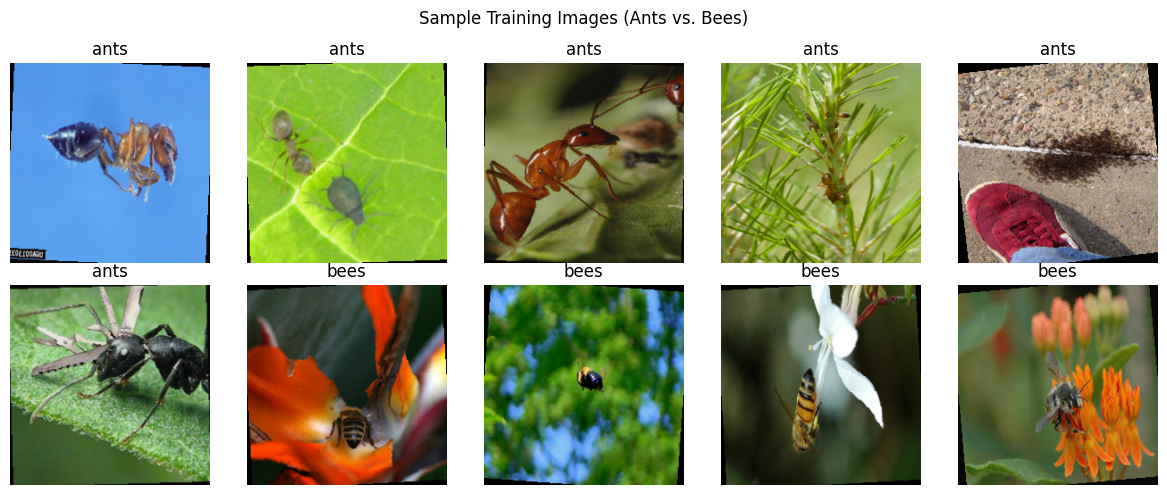

In [9]:
# Visualize some training samples
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
    std=[1/s for s in IMAGENET_STD]
)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.ravel()):
    img, label = train_dataset[i * (len(train_dataset) // 10)]
    img_display = inv_normalize(img).clamp(0, 1)
    ax.imshow(img_display.permute(1, 2, 0))
    ax.set_title(train_dataset.classes[label])
    ax.axis("off")
plt.suptitle("Sample Training Images (Ants vs. Bees)")
plt.tight_layout()

### Approach 1: Feature Extraction (Frozen Backbone)

The simplest form of transfer learning: use the pretrained model as a fixed feature extractor.
1. Load a pretrained model (ResNet-50)
2. Freeze all backbone parameters
3. Replace the classifier head
4. Train only the new head

In [10]:
# Load pretrained ResNet-50
model_extract = models.resnet50(weights='IMAGENET1K_V1')

# Freeze all parameters
for param in model_extract.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# ResNet-50's fc layer: Linear(2048, 1000) -> Linear(2048, 2)
num_features = model_extract.fc.in_features
model_extract.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2),
)

model_extract = model_extract.to(device)

# Check parameter counts
trainable = sum(p.numel() for p in model_extract.parameters() if p.requires_grad)
total = sum(p.numel() for p in model_extract.parameters())
print(f"Trainable: {trainable:,} / {total:,} total ({100*trainable/total:.2f}%)")

Trainable: 4,098 / 23,512,130 total (0.02%)


In [11]:
import copy

# Training utility function
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10,
                scheduler=None, freeze_backbone=False):
    """Train a model and return training history. Restores best weights (by val loss)."""
    criterion = nn.CrossEntropyLoss()
    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        # --- Training ---
        if freeze_backbone:
            # Keep pretrained layers in eval mode; only classifier head trains
            model.eval()
            model.fc.train()
        else:
            model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # --- Validation ---
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        # Save best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"loss: {train_loss:.4f}, acc: {train_acc:.4f}, "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

    # Restore best weights
    model.load_state_dict(best_model_wts)
    print(f"Restored best model weights (val_loss: {best_val_loss:.4f})")
    return history

In [12]:
# Train the feature extraction model
optimizer_extract = optim.Adam(model_extract.fc.parameters(), lr=1e-3)
history_extract = train_model(model_extract, train_loader, val_loader,
                               optimizer_extract, num_epochs=10,
                               freeze_backbone=True)

Epoch 1/10 - loss: 0.5845, acc: 0.6762, val_loss: 0.3180, val_acc: 0.9216
Epoch 2/10 - loss: 0.2631, acc: 0.9385, val_loss: 0.2025, val_acc: 0.9477
Epoch 3/10 - loss: 0.1703, acc: 0.9549, val_loss: 0.1490, val_acc: 0.9608
Epoch 4/10 - loss: 0.1200, acc: 0.9713, val_loss: 0.1419, val_acc: 0.9542
Epoch 5/10 - loss: 0.1163, acc: 0.9713, val_loss: 0.1274, val_acc: 0.9608
Epoch 6/10 - loss: 0.1016, acc: 0.9672, val_loss: 0.1294, val_acc: 0.9542
Epoch 7/10 - loss: 0.0913, acc: 0.9754, val_loss: 0.1211, val_acc: 0.9608
Epoch 8/10 - loss: 0.0892, acc: 0.9795, val_loss: 0.1191, val_acc: 0.9608
Epoch 9/10 - loss: 0.0777, acc: 0.9795, val_loss: 0.1179, val_acc: 0.9608
Epoch 10/10 - loss: 0.0624, acc: 0.9836, val_loss: 0.1200, val_acc: 0.9542
Restored best model weights (val_loss: 0.1179)


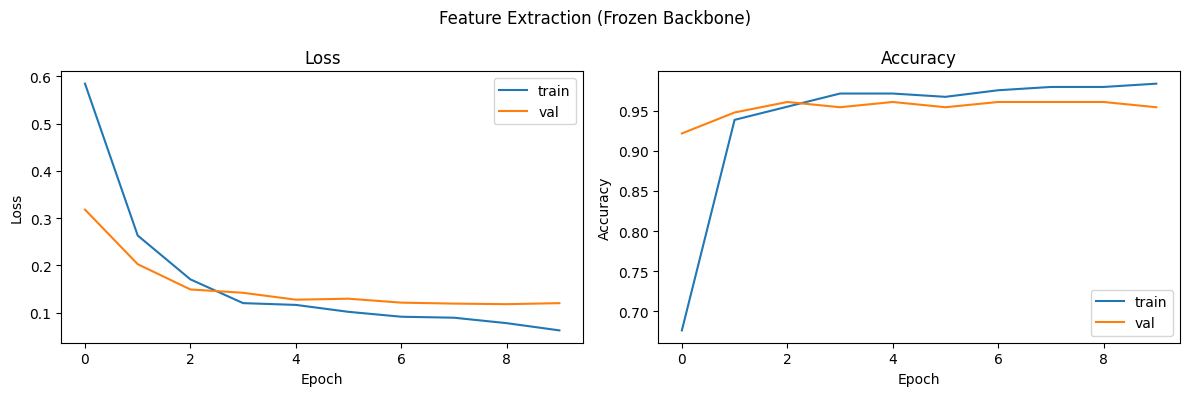

In [13]:
# Plot training curves
def plot_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history["loss"], label="train")
    axs[0].plot(history["val_loss"], label="val")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(history["accuracy"], label="train")
    axs[1].plot(history["val_accuracy"], label="val")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    plt.suptitle(title)
    plt.tight_layout()

plot_history(history_extract, "Feature Extraction (Frozen Backbone)")

💬 **Discuss:** We reached ~93% validation accuracy training only 4,098 parameters out of 23.5M. But note that "bee" and "ant" are both ImageNet classes - so the backbone already knows what these insects look like. Would you expect similar accuracy if the target classes were something *not* in ImageNet (e.g., cell types under a microscope)? Why or why not?

### Approach 2: Fine-Tuning

Feature extraction is a good starting point, but we can often do better by **fine-tuning** - unfreezing some of the pretrained layers and training them alongside the new head.

**Key principles for fine-tuning:**
1. **Start from the feature extraction result** - first train the head with the backbone frozen, then unfreeze and fine-tune
2. **Progressive unfreezing** - unfreeze later layers first (they're more task-specific), keep early layers frozen (they learn general features)
3. **Use a small learning rate** - pretrained weights are already good; large updates would destroy them
4. **Differential learning rates** - use a smaller learning rate for pretrained layers than for the new head

In [14]:
# Start fresh: load a new pretrained ResNet-50
model_finetune = models.resnet50(weights='IMAGENET1K_V1')

# Step 1: Freeze all layers
for param in model_finetune.parameters():
    param.requires_grad = False

# Step 2: Replace the classifier head (same as before)
num_features = model_finetune.fc.in_features
model_finetune.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2),
)
model_finetune = model_finetune.to(device)

# Step 3: Train the head first (warm-up)
optimizer_warmup = optim.Adam(model_finetune.fc.parameters(), lr=1e-3)
print("Phase 1: Training classifier head only...")
history_warmup = train_model(model_finetune, train_loader, val_loader,
                              optimizer_warmup, num_epochs=5,
                              freeze_backbone=True)

Phase 1: Training classifier head only...
Epoch 1/5 - loss: 0.5349, acc: 0.7377, val_loss: 0.3228, val_acc: 0.9412
Epoch 2/5 - loss: 0.2534, acc: 0.9221, val_loss: 0.1646, val_acc: 0.9477
Epoch 3/5 - loss: 0.1591, acc: 0.9631, val_loss: 0.1330, val_acc: 0.9542
Epoch 4/5 - loss: 0.1288, acc: 0.9713, val_loss: 0.1204, val_acc: 0.9542
Epoch 5/5 - loss: 0.0933, acc: 0.9713, val_loss: 0.1275, val_acc: 0.9542
Restored best model weights (val_loss: 0.1204)


In [15]:
# Step 4: Unfreeze later layers for fine-tuning
# ResNet-50 structure: conv1, bn1, layer1, layer2, layer3, layer4, fc
# We'll unfreeze layer4 (the last residual block group)
for param in model_finetune.layer4.parameters():
    param.requires_grad = True

# Check what's now trainable
trainable = sum(p.numel() for p in model_finetune.parameters() if p.requires_grad)
total = sum(p.numel() for p in model_finetune.parameters())
print(f"Trainable after unfreezing layer4: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")

# Use differential learning rates:
# - Small LR for the unfrozen pretrained layers
# - Larger LR for the new classifier head
optimizer_finetune = optim.Adam([
    {"params": model_finetune.layer4.parameters(), "lr": 1e-5},
    {"params": model_finetune.fc.parameters(), "lr": 1e-4},
])

print("\nPhase 2: Fine-tuning layer4 + classifier head...")
history_finetune = train_model(model_finetune, train_loader, val_loader,
                                optimizer_finetune, num_epochs=5)

Trainable after unfreezing layer4: 14,968,834 / 23,512,130 (63.66%)

Phase 2: Fine-tuning layer4 + classifier head...
Epoch 1/5 - loss: 0.2308, acc: 0.9262, val_loss: 0.1550, val_acc: 0.9542
Epoch 2/5 - loss: 0.1712, acc: 0.9549, val_loss: 0.1854, val_acc: 0.9216
Epoch 3/5 - loss: 0.1260, acc: 0.9795, val_loss: 0.1930, val_acc: 0.9150
Epoch 4/5 - loss: 0.1121, acc: 0.9795, val_loss: 0.1863, val_acc: 0.9085
Epoch 5/5 - loss: 0.0949, acc: 0.9754, val_loss: 0.1841, val_acc: 0.9085
Restored best model weights (val_loss: 0.1550)


Best feature extraction val accuracy: 0.9608
Best fine-tuned val accuracy:          0.9542


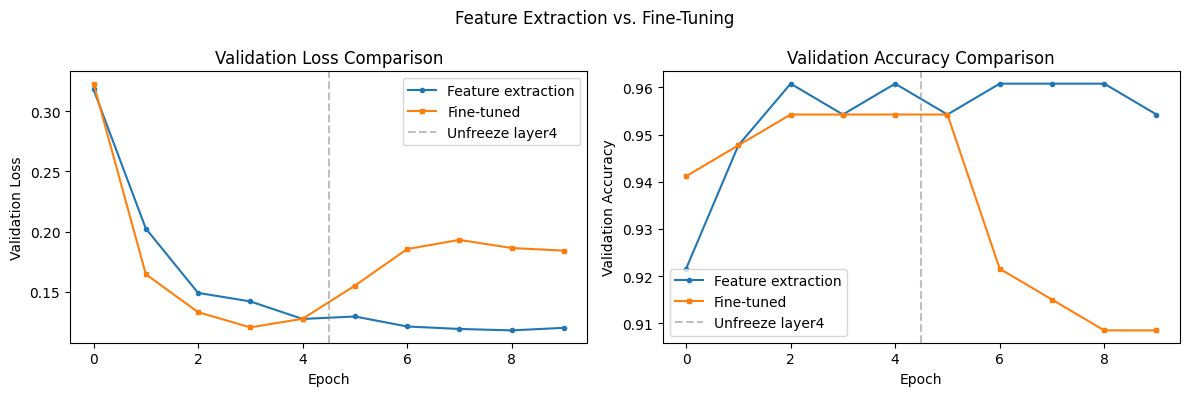

In [16]:
# Compare feature extraction vs. fine-tuning
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Loss comparison
axs[0].plot(history_extract["val_loss"], label="Feature extraction", marker='o', markersize=3)
combined_val_loss = history_warmup["val_loss"] + history_finetune["val_loss"]
axs[0].plot(combined_val_loss, label="Fine-tuned", marker='s', markersize=3)
axs[0].axvline(x=4.5, color='gray', linestyle='--', alpha=0.5, label="Unfreeze layer4")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Validation Loss")
axs[0].set_title("Validation Loss Comparison")
axs[0].legend()

# Accuracy comparison
axs[1].plot(history_extract["val_accuracy"], label="Feature extraction", marker='o', markersize=3)
combined_val_acc = history_warmup["val_accuracy"] + history_finetune["val_accuracy"]
axs[1].plot(combined_val_acc, label="Fine-tuned", marker='s', markersize=3)
axs[1].axvline(x=4.5, color='gray', linestyle='--', alpha=0.5, label="Unfreeze layer4")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Validation Accuracy")
axs[1].set_title("Validation Accuracy Comparison")
axs[1].legend()

plt.suptitle("Feature Extraction vs. Fine-Tuning")
plt.tight_layout()

print(f"Best feature extraction val accuracy: {max(history_extract['val_accuracy']):.4f}")
print(f"Best fine-tuned val accuracy:          {max(combined_val_acc):.4f}")

### When to Use Each Approach

| Scenario | Approach | Why |
|---|---|---|
| Small dataset, similar domain | Feature extraction | Few examples can't support fine-tuning without overfitting |
| Small dataset, different domain | Feature extraction + more augmentation | Risk of overfitting is high; pretrained features may still help |
| Medium dataset, similar domain | Fine-tune top layers | Enough data to adapt higher-level features |
| Large dataset, different domain | Full fine-tuning | Enough data to retrain most/all layers |

**Rules of thumb:**
- Always start with feature extraction as a baseline
- Fine-tune only if you have enough data (hundreds+ per class)
- Use smaller learning rates for pretrained layers (10× to 100× smaller)
- Monitor validation loss carefully - fine-tuning can overfit quickly on small datasets

> **❓ Question 3: Transfer Learning Approaches**
>
> 1. Why do we use a smaller learning rate for pretrained layers compared to the new classifier head during fine-tuning?
> 2. Why do we freeze early layers and only unfreeze later layers? What would happen if we unfroze early layers instead?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Pretrained layers already contain useful feature representations learned from millions of ImageNet images. Using a large learning rate would make aggressive updates that could destroy these carefully learned weights, essentially "forgetting" the pretraining. The new classifier head, however, is randomly initialized and needs larger updates to converge. Differential learning rates let each part train at its own pace - the pretrained layers make small refinements while the new head makes larger adjustments.
>
> 2. Early layers learn general, transferable features (edges, textures, basic shapes) that are useful across virtually all vision tasks. Later layers learn increasingly task-specific features that may need adaptation to the new domain. Unfreezing only later layers lets us adapt the task-specific features while preserving the general features. Unfreezing early layers risks overfitting on the small target dataset - the network might "unlearn" the general features it spent millions of examples learning, replacing them with noise fit to a few hundred training examples.

</details>

> **❓ Question 4: Fine-Tuning Strategy**
>
> 1. We trained the classifier head for 5 epochs before unfreezing layer4. Why not skip the warm-up and unfreeze immediately?
> 2. If you had a dataset of chest X-rays (very different from ImageNet), would you expect transfer learning to help? Why or why not?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. The warm-up phase lets the randomly initialized classifier head learn reasonable weights before the pretrained backbone is modified. Without warm-up, the randomly initialized head produces large, random gradients that propagate back into the pretrained layers, potentially corrupting their learned features. By first training the head to produce sensible outputs, the subsequent gradients during fine-tuning are smaller and more meaningful, leading to stable adaptation of the pretrained features.
>
> 2. Yes, transfer learning typically helps even for domains quite different from ImageNet (like medical images). Research has consistently shown that low-level features (edges, textures, contrast patterns) learned from natural images transfer well to medical imaging. However, the benefit diminishes for very different modalities, and the fine-tuning strategy matters more: you'd likely want to fine-tune more layers (or even all layers) with a carefully tuned learning rate, rather than just doing feature extraction. Studies show that ImageNet-pretrained models used as initialization consistently outperform training from scratch on medical imaging tasks, even with substantial datasets.

</details>

## Part 3: Visualizing CNNs

CNNs are often criticized as "black boxes" - they achieve impressive accuracy, but it's hard to understand *why* they make specific predictions. Visualization techniques help us peek inside:

- **Saliency Maps** - Which input pixels are most important for the prediction?
- **Class Model Visualization** - What does the network think a given class "looks like"?

These tools are essential for debugging models, building trust, and identifying failure modes (e.g., a model that classifies "wolf" by detecting snow in the background).

### Setup: Load a Pretrained Model and Sample Images

In [17]:
# Load pretrained ResNet-50 for visualization
vis_model = models.resnet50(weights='IMAGENET1K_V1')
vis_model = vis_model.to(device)
vis_model.eval()

# ImageNet class labels
# Source: https://github.com/anishathalye/imagenet-simple-labels (MIT License)
import json
with open("data/imagenet-simple-labels.json") as f:
    imagenet_labels = json.load(f)

print(f"Loaded {len(imagenet_labels)} ImageNet class labels")
print(f"Examples: {imagenet_labels[:5]}")

Loaded 1000 ImageNet class labels
Examples: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']


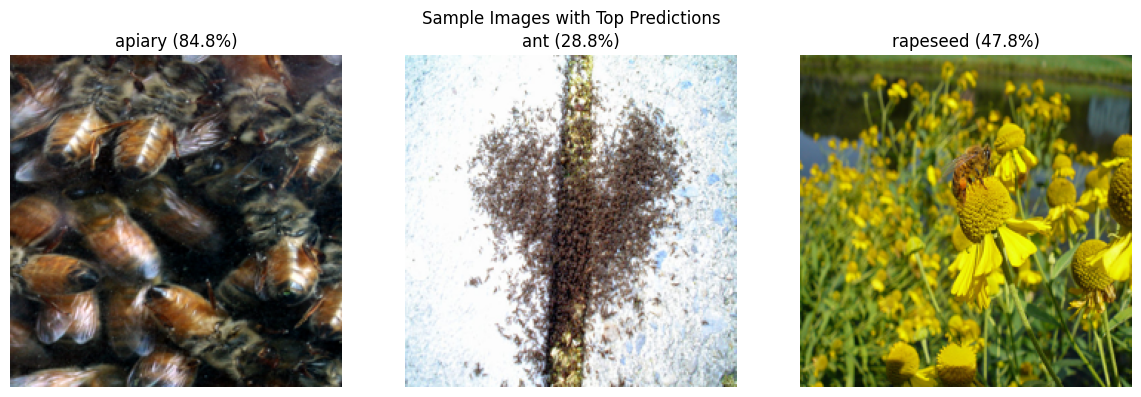

In [18]:
# Helper function to load and preprocess images
def load_image(path, size=224):
    """Load an image, resize it, and return both the tensor and display image."""
    img = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return tensor, img

def show_image(img, title=None):
    """Display a PIL image or tensor."""
    if isinstance(img, torch.Tensor):
        img = inv_normalize(img.squeeze(0).cpu()).clamp(0, 1)
        img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

# Use images from the hymenoptera dataset (already downloaded)
# Pick a few diverse images: 2 bees and 1 ant
bee_images = sorted(glob.glob("data/hymenoptera_data/val/bees/*.jpg"))
ant_images = sorted(glob.glob("data/hymenoptera_data/val/ants/*.jpg"))
sample_paths = [bee_images[0], ant_images[0], bee_images[5]]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, path in zip(axes, sample_paths):
    tensor, img = load_image(path)
    tensor = tensor.to(device)
    with torch.no_grad():
        output = vis_model(tensor)
        probs = F.softmax(output, dim=1)
        top_prob, top_idx = probs.topk(1)

    ax.imshow(img.resize((224, 224)))
    # Show top prediction as title
    top_label = imagenet_labels[top_idx[0, 0].item()]
    top_prob = top_prob[0, 0].item()
    ax.set_title(f"{top_label} ({top_prob:.1%})")
    ax.axis("off")

plt.suptitle("Sample Images with Top Predictions")
plt.tight_layout()

### Saliency Maps

A **saliency map** highlights which pixels in the input image most influence the model's prediction. It is computed by:

1. Forward pass: compute the class score for the target class
2. Backward pass: compute the gradient of the class score with respect to the *input image*
3. Take the absolute value (or max across color channels) of the gradient

Pixels with large gradient magnitudes are "important" - small changes to these pixels would significantly change the model's prediction.

In [19]:
def compute_saliency_map(model, input_tensor, target_class=None):
    """Compute a saliency map for the given input and target class."""
    model.eval()
    # Important: move to device BEFORE setting requires_grad
    # (.to() after requires_grad_ creates a non-leaf tensor on MPS/CUDA)
    input_tensor = input_tensor.clone().detach().to(device).requires_grad_(True)

    # Forward pass
    output = model(input_tensor)

    # Use the predicted class if no target specified
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Zero gradients
    model.zero_grad()

    # Backward pass: gradient of target class score w.r.t. input
    class_score = output[0, target_class]
    class_score.backward()

    # Get the saliency map: max absolute gradient across color channels
    saliency = input_tensor.grad.data.abs().squeeze(0)  # (3, H, W)
    saliency, _ = saliency.max(dim=0)  # (H, W) - max across RGB channels

    return saliency.cpu().numpy()

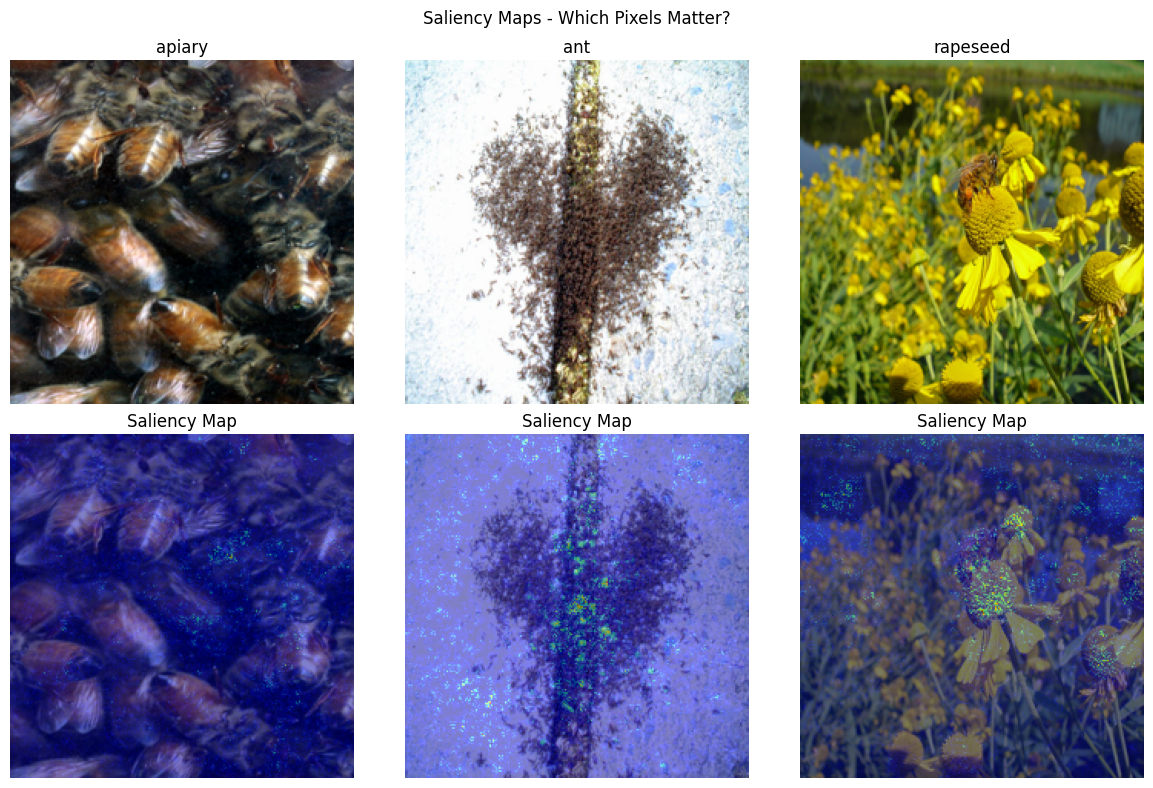

In [20]:
# Generate saliency maps for our sample images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for col, path in enumerate(sample_paths):
    tensor, img = load_image(path)
    saliency = compute_saliency_map(vis_model, tensor)

    # Get predicted class label
    with torch.no_grad():
        output = vis_model(tensor.to(device))
        pred_class = output.argmax(dim=1).item()

    # Original image
    axes[0, col].imshow(img.resize((224, 224)))
    axes[0, col].set_title(imagenet_labels[pred_class])
    axes[0, col].axis("off")

    # Saliency map overlaid
    axes[1, col].imshow(img.resize((224, 224)))
    axes[1, col].imshow(saliency, cmap="jet", alpha=0.5)
    axes[1, col].set_title("Saliency Map")
    axes[1, col].axis("off")

plt.suptitle("Saliency Maps - Which Pixels Matter?")
plt.tight_layout()

💬 **Discuss:** Look at the saliency maps above. Is the model focusing on the insect itself, or on the background? If a saliency map highlighted the flowers instead of the bee, what would that tell you about the model's decision-making?

### Class Model Visualization

Saliency maps show what the model attends to in a *specific input*. **Class model visualization** (Simonyan et al., 2014) answers a different question: *"What does the network think a 'goldfish' or 'spider' looks like?"*

The process uses the same gradient ascent idea, but applied to the **output class score** (logit):
1. Start with a random noise image
2. Forward pass through the full model
3. Compute the logit for the target class
4. Backpropagate to compute gradients w.r.t. the input image
5. Update the input image to increase the class logit (gradient ascent)
6. Repeat for many iterations

This produces a synthetic image that reveals what patterns the network associates with a given class.

Optimizing for 'goldfish' (class 1)... done
Optimizing for 'spider' (class 76)... done
Optimizing for 'flamingo' (class 130)... done
Optimizing for 'bee' (class 309)... done
Optimizing for 'volcano' (class 980)... done
Optimizing for 'school bus' (class 779)... done


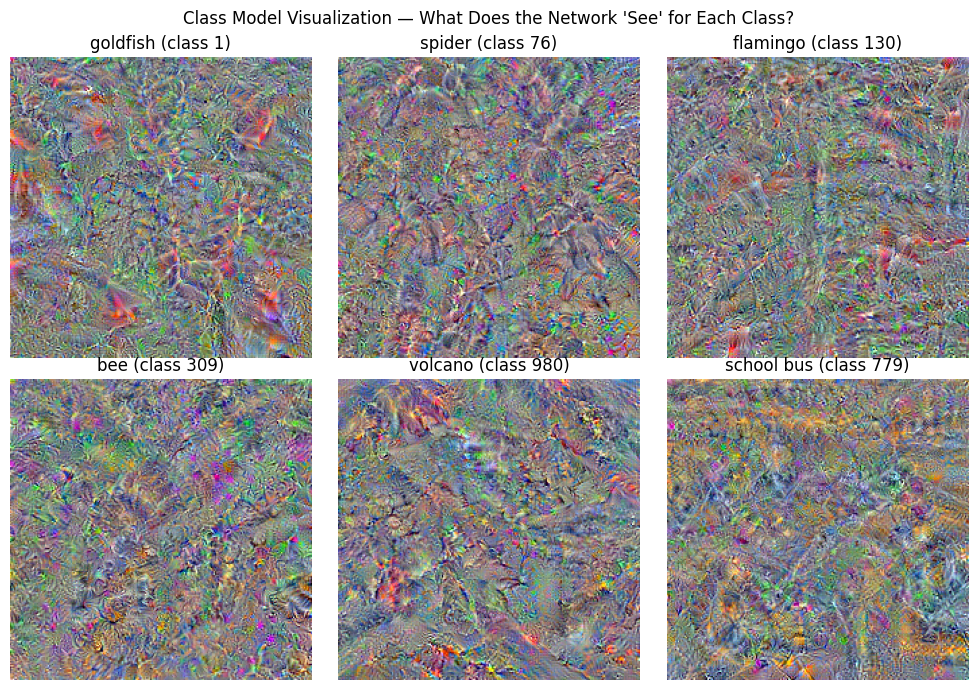

In [21]:
def deprocess_image(img_tensor):
    """Convert an optimized tensor to a displayable image."""
    img = img_tensor.numpy().transpose(1, 2, 0)  # CHW -> HWC
    # Standardize, then rescale to a mid-gray centered range [~0.35, ~0.65]
    # so subtle activation patterns are visible without saturation
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.15
    img += 0.5
    img = np.clip(img, 0, 1)
    return img

def class_model_visualization(model, target_class, img_size=224, lr=0.05,
                               num_iterations=200, tv_weight=1e-4, l2_weight=1e-4):
    """Generate an image that maximizes the logit for a target class (Simonyan et al., 2014)."""
    # Start from random noise
    img = torch.randn(1, 3, img_size, img_size, device=device) * 0.01
    img.requires_grad_(True)

    optimizer = optim.Adam([img], lr=lr)

    for i in range(num_iterations):
        optimizer.zero_grad()

        # Forward pass through the full model
        logits = model(img)

        # Maximize the target class logit
        loss = -logits[0, target_class]

        # Regularization: TV smoothness + L2 to prevent extreme pixel values
        tv_loss = tv_weight * (
            torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) +
            torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
        )
        l2_loss = l2_weight * torch.sum(img ** 2)
        total_loss = loss + tv_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    return img.detach().cpu().squeeze(0)

# Visualize what the network thinks several ImageNet classes look like
target_classes = {
    "goldfish": 1,
    "spider": 76,
    "flamingo": 130,
    "bee": 309,
    "volcano": 980,
    "school bus": 779,
}

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, (class_name, class_idx) in zip(axes.ravel(), target_classes.items()):
    print(f"Optimizing for '{class_name}' (class {class_idx})...", end=" ")
    img_tensor = class_model_visualization(vis_model, target_class=class_idx,
                                            num_iterations=200)
    img = deprocess_image(img_tensor)
    ax.imshow(img)
    ax.set_title(f"{class_name} (class {class_idx})")
    ax.axis("off")
    print("done")

plt.suptitle("Class Model Visualization — What Does the Network 'See' for Each Class?")
plt.tight_layout()

> **❓ Question 5: Class Model Visualization**
>
> 1. How does class model visualization differ from saliency maps in what it reveals about the network?
> 2. What role does total variation (TV) regularization play in generating these visualizations?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Saliency maps are **input-specific** — they show which pixels in a *particular image* most influence the prediction. Class model visualization is **input-independent** — it starts from random noise and uses gradient ascent to synthesize what the network considers an "ideal" example of a class. Saliency maps answer "what did the model look at *here*?" while class model visualization answers "what has the model learned about this class *in general*?"
>
> 2. TV regularization penalizes high-frequency noise in the generated image by encouraging neighboring pixels to have similar values. Without it, gradient ascent tends to produce adversarial-looking images with high-frequency patterns that technically maximize the class logit but are visually meaningless. TV regularization acts as a smoothness prior, producing more interpretable visualizations that better reflect the natural patterns the network associates with each class.

</details>

## TEAM ACTIVITY: Investigating CNN Predictions

> **🏋️ TEAM ACTIVITY:** In this activity, you'll use saliency maps to investigate what a pretrained model is "looking at" when it makes predictions. You'll examine both correct and incorrect predictions to understand model behavior.

We'll use our pretrained ResNet-50 model with additional sample images.

**Task 1: Select and classify images**

Select a set of images from the hymenoptera dataset (or your own images). Classify each image using the pretrained ResNet-50 and display the top-3 predictions for each.

*Hint: Use `glob.glob` to find image paths and the `load_image` function from Part 3.*

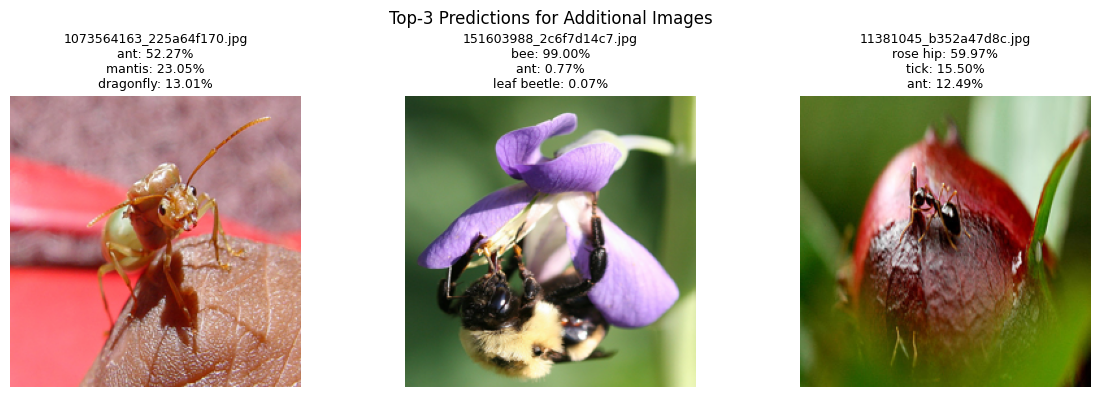

In [22]:
# your code here
# BEGIN SOLUTION
# Select additional images from the hymenoptera dataset
task_paths = [ant_images[2], bee_images[10], ant_images[5]]

fig, axes = plt.subplots(1, len(task_paths), figsize=(4 * len(task_paths), 4))
if len(task_paths) == 1:
    axes = [axes]

for ax, path in zip(axes, task_paths):
    tensor, img = load_image(path)
    tensor = tensor.to(device)
    with torch.no_grad():
        output = vis_model(tensor)
        probs = F.softmax(output, dim=1)
        top3_probs, top3_idxs = probs.topk(3)

    ax.imshow(img.resize((224, 224)))
    title_lines = [os.path.basename(path)]
    for i in range(3):
        label = imagenet_labels[top3_idxs[0, i].item()]
        prob = top3_probs[0, i].item()
        title_lines.append(f"{label}: {prob:.2%}")
    ax.set_title("\n".join(title_lines), fontsize=9)
    ax.axis("off")

plt.suptitle("Top-3 Predictions for Additional Images")
plt.tight_layout()
# END SOLUTION

**Task 2: Generate saliency map visualizations**

For each image from Task 1, generate a saliency map targeting the model's top prediction. Display the original images alongside their saliency maps.

*Hint: Use the `compute_saliency_map` function from Part 3.*

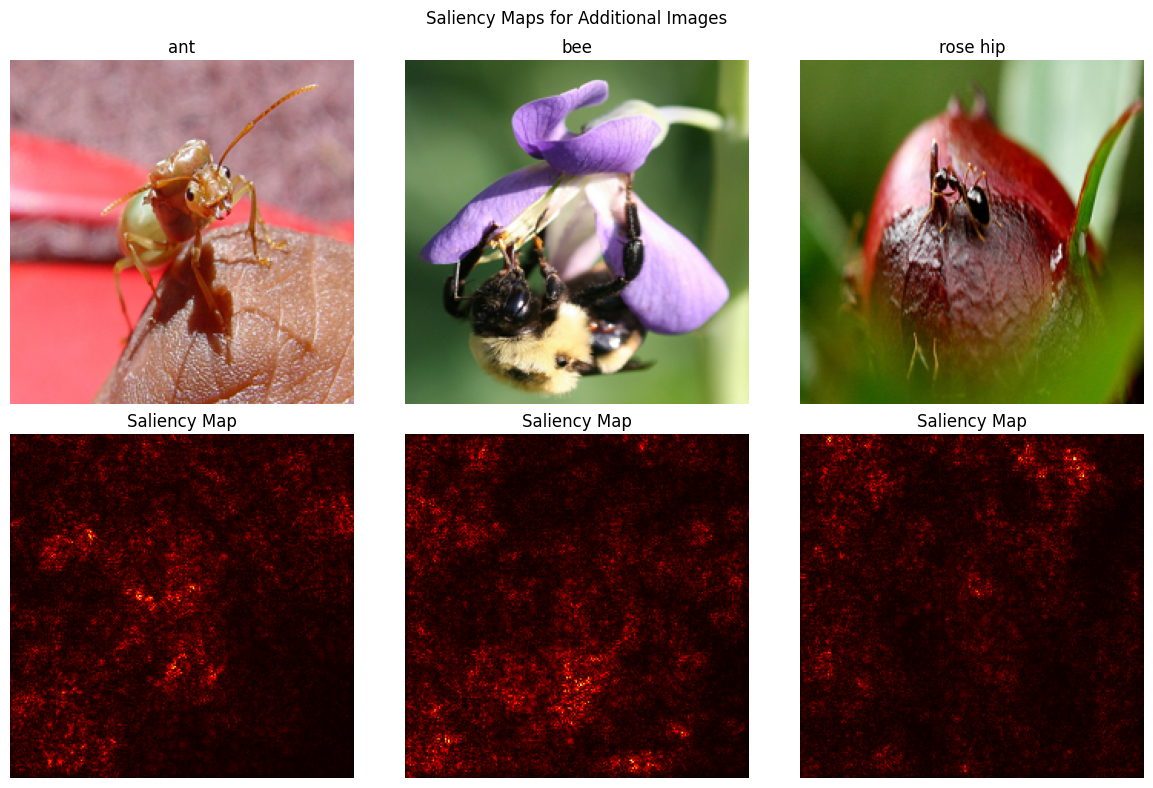

In [23]:
# your code here
# BEGIN SOLUTION
fig, axes = plt.subplots(2, len(task_paths), figsize=(4 * len(task_paths), 8))

for col, path in enumerate(task_paths):
    tensor, img = load_image(path)
    img_resized = img.resize((224, 224))

    saliency = compute_saliency_map(vis_model, tensor)

    # Get predicted class
    with torch.no_grad():
        output = vis_model(tensor.to(device))
        pred_class = output.argmax(dim=1).item()

    # Original
    axes[0, col].imshow(img_resized)
    axes[0, col].set_title(f"{imagenet_labels[pred_class]}")
    axes[0, col].axis("off")

    # Saliency map
    axes[1, col].imshow(saliency, cmap="hot")
    axes[1, col].set_title("Saliency Map")
    axes[1, col].axis("off")

plt.suptitle("Saliency Maps for Additional Images")
plt.tight_layout()
# END SOLUTION

**Task 3: Analyze and discuss**

Look at the saliency map visualizations from Task 2 and answer these questions with your team:

1. Is the model focusing on the object itself, or on background/context features?
2. Are there any cases where the model seems to rely on spurious correlations (e.g., background, watermarks, common co-occurring objects)?
3. If you found a case where the model attends to the wrong features, how would you improve it? Consider: more training data, better augmentation, different model, fine-tuning on a curated dataset.

Write your observations below.

In [24]:
# your code here
# BEGIN SOLUTION
# Discussion answers will vary by team. Example observations:
#
# 1. For correctly classified images, saliency maps typically highlight
#    pixels on the object itself (e.g., the ant's body, the bee's wings),
#    showing the model focuses on relevant features.
#
# 2. Some models trained on ImageNet may pick up on background context
#    or co-occurring features rather than the object itself. Saliency maps
#    can reveal these spurious correlations.
#
# 3. To improve models that rely on spurious features:
#    - Collect more diverse training data with varied backgrounds
#    - Use stronger data augmentation (random backgrounds, cutout)
#    - Fine-tune on a curated dataset with diverse contexts
#    - Consider using techniques like "right for the right reasons"
#      that explicitly penalize attention to background regions
print("See discussion in code comments above.")
# END SOLUTION

See discussion in code comments above.


**End of team activity**